# <p style="background-color:green;font-family:newtimeroman;color:#FFF9ED;font-size:200%;text-align:center;border-radius:10px 10px;">ASL Classification Using Transfer Learning</p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

%matplotlib inline
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '/kaggle/input/asl-dataset/asl_dataset/asl_dataset/'

data = tf.keras.preprocessing.image_dataset_from_directory(data_dir)

Found 2515 files belonging to 36 classes.


2023-01-17 03:39:23.801393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 03:39:23.997442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 03:39:23.998265: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 03:39:24.001068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [3]:
from tensorflow.keras import backend as K

def precision(y_true, y_pred):  
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

In [4]:
import os
num_skipped = 0
for folder_name in ("0","1","2","3","4","5","6","7","8","9","a","b","c","d","e","f","g","h","i","j","k","l","m","n","o"
                    ,"p","q","r","s","t","u","v","w","x","y","z"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
print("Deleted %d images" % num_skipped)


Deleted 0 images


In [5]:
datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
        validation_split = 0.2)

In [6]:
height = 299
width = 299
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

In [7]:
train_data = datagen.flow_from_directory(
    data_dir,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    target_size = img_size
)

val_data = datagen.flow_from_directory(
    data_dir,
    batch_size = batch_size,
    class_mode='categorical',
    subset = 'validation',
    target_size = img_size
)

Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


In [8]:
num_classes = len(data.class_names)
print('.... Number of Classes : {0} ....'.format(num_classes))

.... Number of Classes : 36 ....


2023-01-17 03:39:39.208201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


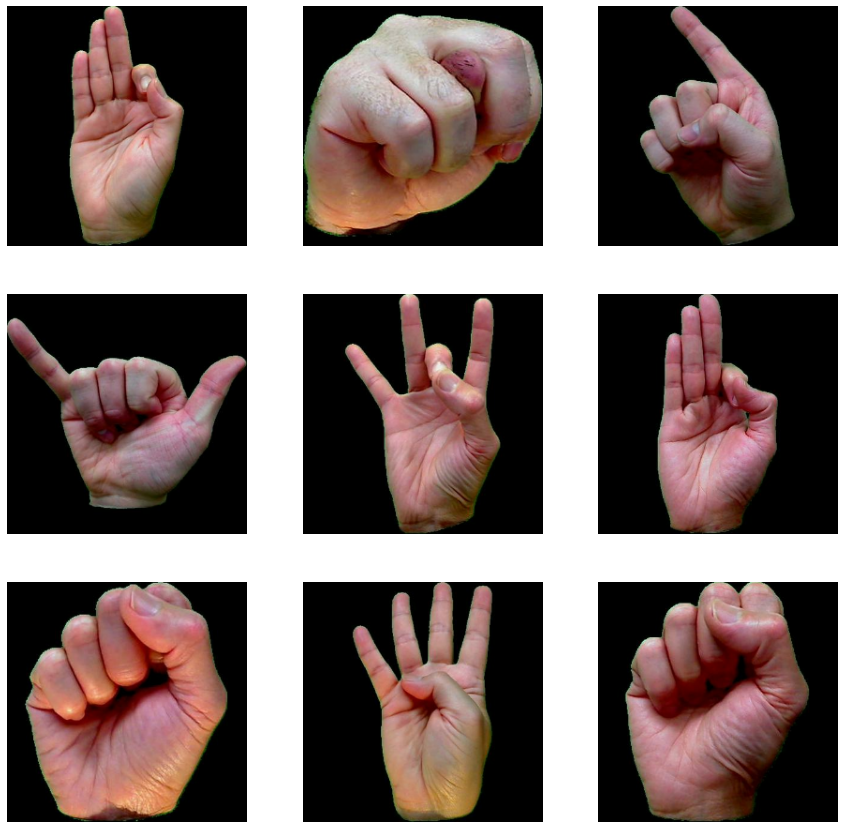

In [9]:
def show_img(data):
    plt.figure(figsize=(15,15))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(data)

In [10]:
pre_trained = InceptionV3(weights='imagenet', include_top=False, input_shape=img_shape, pooling='max')

for layer in pre_trained.layers:
    layer.trainable = False

87924736/87910968 [==============================] - 1s 0us/step


In [11]:
# Define the metrics
model_accuracy = tf.keras.metrics.Accuracy()
model_precision = tf.keras.metrics.Precision()
model_recall = tf.keras.metrics.Recall()

In [12]:
x = pre_trained.output
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs = pre_trained.input, outputs = predictions)
model.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', model_precision, model_recall])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
STEP_SIZE_TRAIN = train_data.n // train_data.batch_size
STEP_SIZE_VALID = val_data.n // val_data.batch_size

history = model.fit_generator(train_data,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_data,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = 100,
                    verbose = 1)

Epoch 1/100


2023-01-17 03:39:50.010636: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


62/62 [==============================] - 69s 933ms/step - loss: 2.4968 - accuracy: 0.4061 - precision: 0.5238 - recall: 0.3384 - val_loss: 4.8739 - val_accuracy: 0.2250 - val_precision: 0.2311 - val_recall: 0.2042
Epoch 2/100
62/62 [==============================] - 56s 896ms/step - loss: 1.5433 - accuracy: 0.5990 - precision: 0.6429 - recall: 0.5545 - val_loss: 2.7578 - val_accuracy: 0.4292 - val_precision: 0.4729 - val_recall: 0.4000
Epoch 3/100
62/62 [==============================] - 56s 912ms/step - loss: 1.3470 - accuracy: 0.6697 - precision: 0.7125 - recall: 0.6359 - val_loss: 1.7641 - val_accuracy: 0.5958 - val_precision: 0.6210 - val_recall: 0.5667
Epoch 4/100
62/62 [==============================] - 56s 913ms/step - loss: 1.0477 - accuracy: 0.7182 - precision: 0.7469 - recall: 0.6914 - val_loss: 1.5250 - val_accuracy: 0.6521 - val_precision: 0.6909 - val_recall: 0.6333
Epoch 5/100
62/62 [==============================] - 56s 905ms/step - loss: 0.9661 - accuracy: 0.7419 - prec

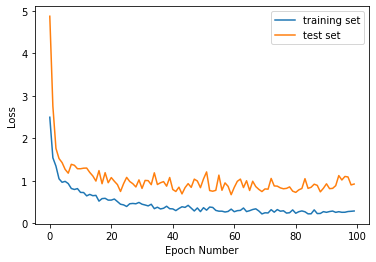

In [15]:
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training set')
plt.plot(history.history['val_loss'], label='test set')
plt.legend()

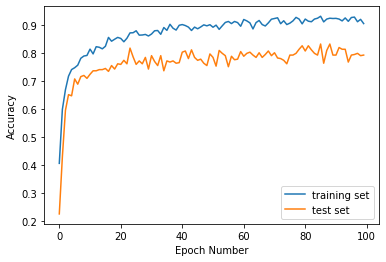

In [16]:
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training set')
plt.plot(history.history['val_accuracy'], label='test set')
plt.legend()

In [17]:
model_name = 'Sign_InceptionV3.h5'
model.save(model_name, save_format='h5')

In [18]:
class_map = train_data.class_indices
classes = []
for key in class_map.keys():
    classes.append(key)

In [19]:
def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(299, 299))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0)
    img_processed /= 255.
    
    prediction = model.predict(img_processed)
    
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(str(classes[index]).title()), size=18, color='red')
    plt.imshow(img_array)

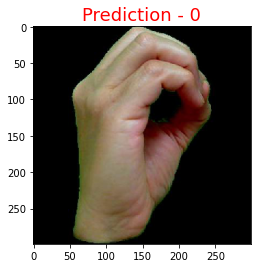

In [20]:
predict_image('/kaggle/input/asl-dataset/asl_dataset/0/hand2_0_dif_seg_2_cropped.jpeg', model)

In [21]:
Y_pred = model.predict_generator(val_data)
y_pred = np.argmax(Y_pred, axis=1)

Text(0.5, 33.0, 'Predicted label')

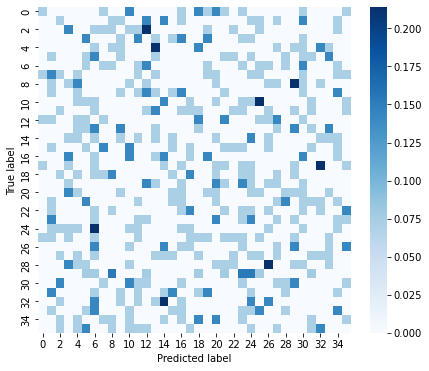

In [22]:
cf_mat = confusion_matrix(val_data.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [23]:
cf_mat

array([[1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 2, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0]])

In [24]:
df = pd.DataFrame(cf_mat)

In [25]:
print(df)

    0   1   2   3   4   5   6   7   8   9   ...  26  27  28  29  30  31  32  \
0    1   0   0   0   0   0   0   1   0   0  ...   0   0   0   0   1   0   0   
1    0   0   1   0   0   0   0   0   1   1  ...   0   1   0   0   2   0   0   
2    0   0   0   2   0   0   1   1   1   0  ...   0   0   0   0   0   0   0   
3    0   0   0   0   0   2   0   0   0   1  ...   0   0   0   0   1   0   0   
4    0   0   0   0   0   0   1   0   1   1  ...   0   1   0   1   1   0   2   
5    0   1   0   0   0   1   2   0   0   1  ...   0   0   1   0   1   1   0   
6    0   0   0   0   0   1   0   1   1   0  ...   1   0   1   0   2   0   0   
7    1   2   1   0   1   0   0   0   0   0  ...   0   0   0   0   1   0   0   
8    0   1   0   1   2   0   0   0   0   0  ...   1   1   0   3   1   0   1   
9    0   1   0   0   1   0   0   0   0   1  ...   0   0   0   0   1   0   0   
10   0   0   0   0   1   1   1   0   0   0  ...   0   0   0   0   0   1   0   
11   0   0   1   0   0   0   1   0   0   0  ...   1 

In [28]:
loss, accuracy, precision, recall = model.evaluate(val_data, verbose=0)

In [29]:
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

Precision:  0.8145161271095276
Recall:  0.8031809329986572
Accuracy:  0.807157039642334
Loss:  1.0084803104400635


In [30]:
f1_score = 2*(precision*recall)/(precision+recall)

In [33]:
print(f1_score)

0.8088088172337197


In [34]:
model.metrics_names

['loss', 'accuracy', 'precision', 'recall']